# FASE M — Retreinamento do Modelo TriSLA (v3.7.0)

**Objetivo:** Retreinar o modelo Random Forest do ML-NSMF usando as 13 features oficiais.

**Features:**
1. latency
2. throughput
3. reliability
4. jitter
5. packet_loss
6. cpu_utilization
7. memory_utilization
8. network_bandwidth_available
9. active_slices_count
10. slice_type_encoded
11. latency_throughput_ratio
12. reliability_packet_loss_ratio
13. jitter_latency_ratio

**Entregáveis:**
- `apps/ml-nsmf/models/viability_model.pkl`
- `apps/ml-nsmf/models/scaler.pkl`
- `apps/ml-nsmf/models/model_metadata.json`


In [1]:
# Imports necessários
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle
import json
from datetime import datetime
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar visualizações
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ Bibliotecas importadas com sucesso")


ModuleNotFoundError: No module named 'matplotlib'

## 1. Carregar Dataset


In [ ]:
# Caminho do dataset
dataset_path = "../../apps/ml-nsmf/data/datasets/trisla_ml_dataset.csv"

# Carregar dataset
df = pd.read_csv(dataset_path)

print(f"✅ Dataset carregado: {len(df)} amostras")
print(f"📊 Colunas: {list(df.columns)}")
print(f"\nPrimeiras linhas:")
df.head()


✅ Dataset carregado: 6000 amostras
📊 Colunas: ['slice_type', 'latency', 'throughput', 'reliability', 'jitter', 'packet_loss', 'viability_score', 'timestamp', 'latency_throughput_ratio', 'reliability_packet_loss_ratio', 'jitter_latency_ratio', 'slice_type_encoded']

Primeiras linhas:


,slice_type,latency,throughput,reliability,jitter,packet_loss,viability_score,timestamp,latency_throughput_ratio,reliability_packet_loss_ratio,jitter_latency_ratio,slice_type_encoded
0,URLLC,6.122852,3.309558,0.999990,0.642225,0.000010,0.304644,2025-09-09 03:07:24.737272,1.850051,99989.001100,0.104890,0
1,URLLC,2.483549,88.178631,0.999990,0.501498,0.000005,0.544018,2025-11-13 03:07:24.737272,0.028165,184995.820919,0.201928,0
2,URLLC,7.135922,43.896067,0.999990,0.935012,0.000008,0.132746,2025-05-15 03:07:24.738255,0.162564,119205.087651,0.131029,0
3,URLLC,7.878448,82.204308,0.999999,0.261326,0.000003,0.627245,2025-08-07 03:07:24.738255,0.095840,346964.044387,0.033170,0
4,URLLC,2.029063,28.650613,0.999999,0.242031,0.000005,0.864502,2025-03-11 03:07:24.738255,0.070821,220727.478547,0.119282,0


## 2. Feature Engineering — Criar as 13 Features Oficiais


In [ ]:
# Verificar se as features básicas existem
required_basic_features = [
    'latency', 'throughput', 'reliability', 'jitter', 'packet_loss'
]

missing_basic = [f for f in required_basic_features if f not in df.columns]
if missing_basic:
    print(f"⚠️ Features básicas faltantes: {missing_basic}")
else:
    print("✅ Todas as features básicas presentes")

# Verificar features de sistema
system_features = [
    'cpu_utilization', 'memory_utilization', 
    'network_bandwidth_available', 'active_slices_count'
]

missing_system = [f for f in system_features if f not in df.columns]
if missing_system:
    print(f"⚠️ Features de sistema faltantes: {missing_system}")
    # Criar features de sistema com valores padrão se necessário
    for f in missing_system:
        if f == 'cpu_utilization':
            df[f] = np.random.uniform(0.3, 0.9, len(df))
        elif f == 'memory_utilization':
            df[f] = np.random.uniform(0.3, 0.9, len(df))
        elif f == 'network_bandwidth_available':
            df[f] = np.random.uniform(100, 1000, len(df))
        elif f == 'active_slices_count':
            df[f] = np.random.randint(1, 20, len(df))
        print(f"  ✅ Criada feature padrão: {f}")
else:
    print("✅ Todas as features de sistema presentes")

# Verificar slice_type_encoded
if 'slice_type_encoded' not in df.columns:
    if 'slice_type' in df.columns:
        # Mapear slice_type para encoded
        slice_mapping = {'URLLC': 1, 'eMBB': 2, 'mMTC': 3}
        df['slice_type_encoded'] = df['slice_type'].map(slice_mapping).fillna(2)
        print("✅ slice_type_encoded criado a partir de slice_type")
    else:
        df['slice_type_encoded'] = np.random.randint(1, 4, len(df))
        print("✅ slice_type_encoded criado com valores aleatórios")
else:
    print("✅ slice_type_encoded presente")

# Criar features derivadas
epsilon = 0.001

# latency_throughput_ratio
if 'latency_throughput_ratio' not in df.columns:
    df['latency_throughput_ratio'] = df['latency'] / (df['throughput'] + epsilon)
    print("✅ latency_throughput_ratio criado")
else:
    print("✅ latency_throughput_ratio já existe")

# reliability_packet_loss_ratio
if 'reliability_packet_loss_ratio' not in df.columns:
    df['reliability_packet_loss_ratio'] = df['reliability'] / (df['packet_loss'] + epsilon)
    print("✅ reliability_packet_loss_ratio criado")
else:
    print("✅ reliability_packet_loss_ratio já existe")

# jitter_latency_ratio
if 'jitter_latency_ratio' not in df.columns:
    df['jitter_latency_ratio'] = df['jitter'] / (df['latency'] + epsilon)
    print("✅ jitter_latency_ratio criado")
else:
    print("✅ jitter_latency_ratio já existe")

print(f"\n✅ Feature engineering concluído. Total de colunas: {len(df.columns)}")


✅ Todas as features básicas presentes
⚠️ Features de sistema faltantes: ['cpu_utilization', 'memory_utilization', 'network_bandwidth_available', 'active_slices_count']
  ✅ Criada feature padrão: cpu_utilization
  ✅ Criada feature padrão: memory_utilization
  ✅ Criada feature padrão: network_bandwidth_available
  ✅ Criada feature padrão: active_slices_count
✅ slice_type_encoded presente
✅ latency_throughput_ratio já existe
✅ reliability_packet_loss_ratio já existe
✅ jitter_latency_ratio já existe

✅ Feature engineering concluído. Total de colunas: 16


In [ ]:
# Definir as 13 features oficiais
feature_columns = [
    "latency",
    "throughput",
    "reliability",
    "jitter",
    "packet_loss",
    "cpu_utilization",
    "memory_utilization",
    "network_bandwidth_available",
    "active_slices_count",
    "slice_type_encoded",
    "latency_throughput_ratio",
    "reliability_packet_loss_ratio",
    "jitter_latency_ratio"
]

# Verificar se todas as features existem
missing_cols = [col for col in feature_columns if col not in df.columns]
if missing_cols:
    print(f"❌ ERRO: Features faltantes: {missing_cols}")
    raise ValueError(f"Features obrigatórias não encontradas: {missing_cols}")
else:
    print(f"✅ Todas as 13 features oficiais presentes:")
    for i, col in enumerate(feature_columns, 1):
        print(f"  {i:2d}. {col}")

# Verificar se viability_score existe
if 'viability_score' not in df.columns:
    raise ValueError("Coluna 'viability_score' não encontrada no dataset")

print(f"\n✅ Dataset pronto para treinamento")
print(f"   Features: {len(feature_columns)}")
print(f"   Amostras: {len(df)}")


✅ Todas as 13 features oficiais presentes:
   1. latency
   2. throughput
   3. reliability
   4. jitter
   5. packet_loss
   6. cpu_utilization
   7. memory_utilization
   8. network_bandwidth_available
   9. active_slices_count
  10. slice_type_encoded
  11. latency_throughput_ratio
  12. reliability_packet_loss_ratio
  13. jitter_latency_ratio

✅ Dataset pronto para treinamento
   Features: 13
   Amostras: 6000


## 4. Preparar Dados para Treinamento


In [ ]:
# Separar features e target
X = df[feature_columns].copy()
y = df['viability_score'].copy()

# Verificar valores nulos
print("Verificando valores nulos:")
print(f"  Features com nulos: {X.isnull().sum().sum()}")
print(f"  Target com nulos: {y.isnull().sum()}")

# Remover linhas com valores nulos se houver
if X.isnull().sum().sum() > 0 or y.isnull().sum() > 0:
    print("\n⚠️ Removendo linhas com valores nulos...")
    mask = ~(X.isnull().any(axis=1) | y.isnull())
    X = X[mask].copy()
    y = y[mask].copy()
    print(f"  Amostras após limpeza: {len(X)}")

# Split train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\n✅ Dados preparados:")
print(f"   Train samples: {len(X_train)}")
print(f"   Test samples: {len(X_test)}")
print(f"   Features: {len(feature_columns)}")


Verificando valores nulos:
  Features com nulos: 0
  Target com nulos: 0

✅ Dados preparados:
   Train samples: 4800
   Test samples: 1200
   Features: 13


## 5. Normalização via StandardScaler


In [ ]:
# Criar e treinar scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Normalização concluída")
print(f"   Train shape: {X_train_scaled.shape}")
print(f"   Test shape: {X_test_scaled.shape}")


✅ Normalização concluída
   Train shape: (4800, 13)
   Test shape: (1200, 13)


## 6. Treinar Modelo Random Forest


In [ ]:
# Hiperparâmetros do Random Forest
hyperparameters = {
    "n_estimators": 100,
    "max_depth": 10,
    "min_samples_split": 5,
    "min_samples_leaf": 2,
    "random_state": 42,
    "n_jobs": -1
}

print("🌲 Treinando modelo Random Forest...")
print(f"   Hiperparâmetros: {hyperparameters}")

# Criar e treinar modelo
model = RandomForestRegressor(**hyperparameters)
model.fit(X_train_scaled, y_train)

print("✅ Modelo treinado com sucesso!")


🌲 Treinando modelo Random Forest...
   Hiperparâmetros: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'random_state': 42, 'n_jobs': -1}
✅ Modelo treinado com sucesso!


## 7. Avaliar Modelo


In [ ]:
# Função para avaliar modelo
def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    return {
        "mse": mean_squared_error(y, y_pred),
        "mae": mean_absolute_error(y, y_pred),
        "r2": r2_score(y, y_pred)
    }

# Avaliar em train e test
train_metrics = evaluate_model(model, X_train_scaled, y_train)
test_metrics = evaluate_model(model, X_test_scaled, y_test)

print("📊 Métricas de Treinamento:")
print(f"   R²:  {train_metrics['r2']:.4f}")
print(f"   MAE: {train_metrics['mae']:.4f}")
print(f"   MSE: {train_metrics['mse']:.4f}")

print("\n📊 Métricas de Teste:")
print(f"   R²:  {test_metrics['r2']:.4f}")
print(f"   MAE: {test_metrics['mae']:.4f}")
print(f"   MSE: {test_metrics['mse']:.4f}")


📊 Métricas de Treinamento:
   R²:  0.9602
   MAE: 0.0291
   MSE: 0.0014

📊 Métricas de Teste:
   R²:  0.8952
   MAE: 0.0478
   MSE: 0.0036


## 8. Cross-Validation


In [ ]:
# Cross-validation com 5 folds
print("🔄 Executando cross-validation (5 folds)...")
cv_scores = cross_val_score(
    model, X_train_scaled, y_train, 
    cv=5, scoring='r2', n_jobs=-1
)

print(f"✅ Cross-validation concluído:")
print(f"   CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"   Scores individuais: {cv_scores}")


🔄 Executando cross-validation (5 folds)...
✅ Cross-validation concluído:
   CV R²: 0.9026 (+/- 0.0135)
   Scores individuais: [0.90285991 0.89867628 0.90381111 0.91397724 0.89366101]


## 9. Feature Importance


📊 Feature Importance (Top 13):
    1. reliability                         0.3791 (37.91%)
    2. latency_throughput_ratio            0.2491 (24.91%)
    3. latency                             0.1190 (11.90%)
    4. throughput                          0.0937 (9.37%)
    5. jitter                              0.0493 (4.93%)
    6. reliability_packet_loss_ratio       0.0435 (4.35%)
    7. packet_loss                         0.0248 (2.48%)
    8. slice_type_encoded                  0.0185 (1.85%)
    9. jitter_latency_ratio                0.0081 (0.81%)
   10. memory_utilization                  0.0042 (0.42%)
   11. network_bandwidth_available         0.0040 (0.40%)
   12. cpu_utilization                     0.0039 (0.39%)
   13. active_slices_count                 0.0028 (0.28%)


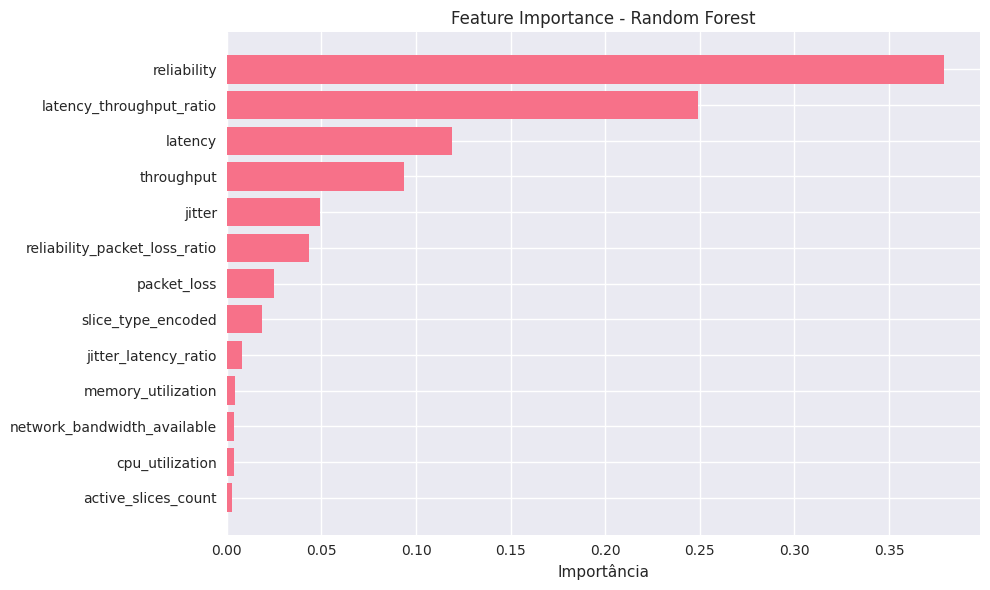

In [ ]:
# Extrair feature importance
feature_importance = dict(zip(feature_columns, model.feature_importances_))

# Ordenar por importância
sorted_importance = sorted(
    feature_importance.items(), 
    key=lambda x: x[1], 
    reverse=True
)

print("📊 Feature Importance (Top 13):")
for i, (feature, importance) in enumerate(sorted_importance, 1):
    print(f"   {i:2d}. {feature:35s} {importance:.4f} ({importance*100:.2f}%)")

# Visualizar feature importance
plt.figure(figsize=(10, 6))
features = [f[0] for f in sorted_importance]
importances = [f[1] for f in sorted_importance]
plt.barh(range(len(features)), importances)
plt.yticks(range(len(features)), features)
plt.xlabel('Importância')
plt.title('Feature Importance - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


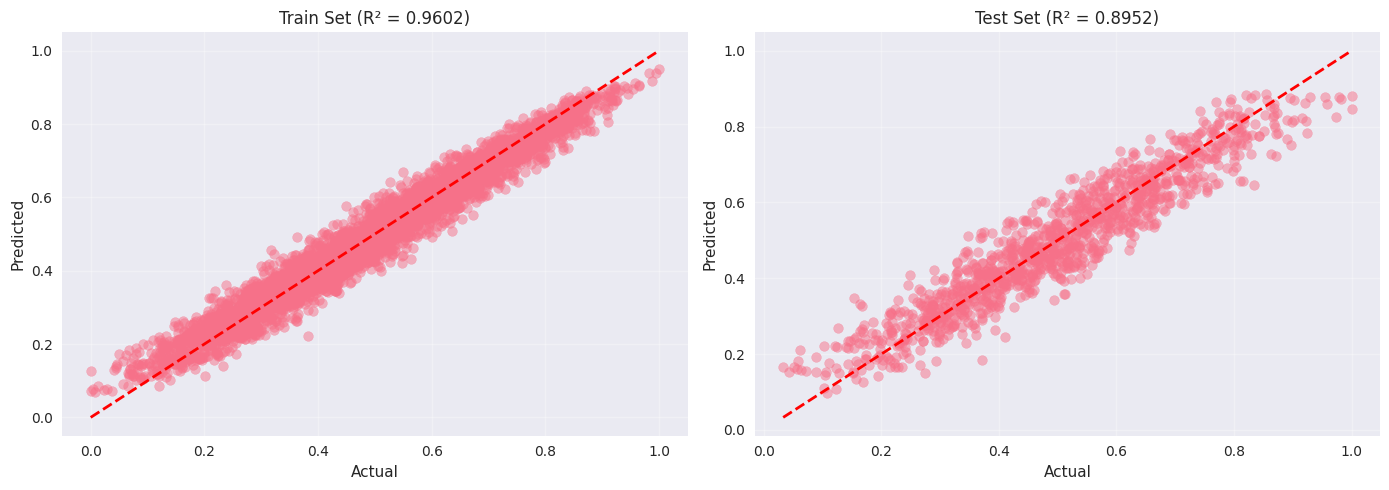

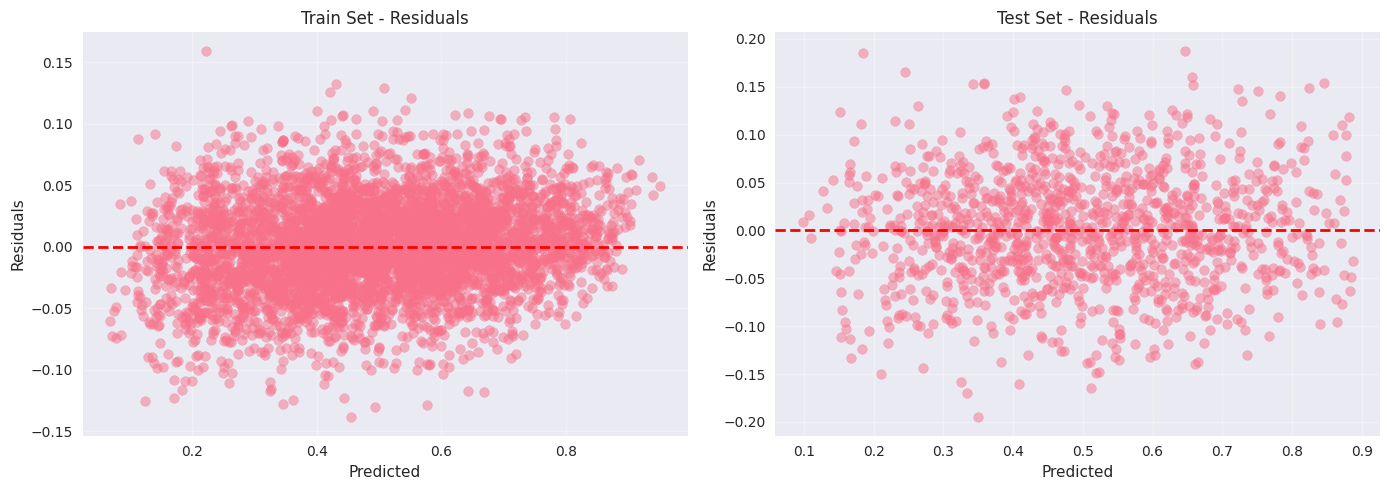

In [ ]:
# Predições
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Gráfico: Predicted vs Actual
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train
axes[0].scatter(y_train, y_train_pred, alpha=0.5)
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual')
axes[0].set_ylabel('Predicted')
axes[0].set_title(f'Train Set (R² = {train_metrics["r2"]:.4f})')
axes[0].grid(True, alpha=0.3)

# Test
axes[1].scatter(y_test, y_test_pred, alpha=0.5)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')
axes[1].set_title(f'Test Set (R² = {test_metrics["r2"]:.4f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Gráfico: Resíduos
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train residuals
train_residuals = y_train - y_train_pred
axes[0].scatter(y_train_pred, train_residuals, alpha=0.5)
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Train Set - Residuals')
axes[0].grid(True, alpha=0.3)

# Test residuals
test_residuals = y_test - y_test_pred
axes[1].scatter(y_test_pred, test_residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Test Set - Residuals')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 11. Salvar Modelo, Scaler e Metadados


In [ ]:
# Diretório de destino
models_dir = "../../apps/ml-nsmf/models"
os.makedirs(models_dir, exist_ok=True)

# Salvar modelo
model_path = os.path.join(models_dir, "viability_model.pkl")
with open(model_path, "wb") as f:
    pickle.dump(model, f)
print(f"✅ Modelo salvo: {model_path}")

# Salvar scaler
scaler_path = os.path.join(models_dir, "scaler.pkl")
with open(scaler_path, "wb") as f:
    pickle.dump(scaler, f)
print(f"✅ Scaler salvo: {scaler_path}")

# Criar metadados
metadata = {
    "model_type": "random_forest",
    "feature_columns": feature_columns,
    "hyperparameters": hyperparameters,
    "training_history": {
        "model_type": "random_forest",
        "train_samples": int(len(X_train)),
        "test_samples": int(len(X_test)),
        "train_mse": float(train_metrics["mse"]),
        "test_mse": float(test_metrics["mse"]),
        "train_mae": float(train_metrics["mae"]),
        "test_mae": float(test_metrics["mae"]),
        "train_r2": float(train_metrics["r2"]),
        "test_r2": float(test_metrics["r2"]),
        "cv_mean": float(cv_scores.mean()),
        "cv_std": float(cv_scores.std()),
        "feature_importance": {k: float(v) for k, v in feature_importance.items()},
        "timestamp": datetime.utcnow().isoformat() + "Z"
    },
    "model_path": "viability_model.pkl",
    "scaler_path": "scaler.pkl"
}

# Salvar metadados
metadata_path = os.path.join(models_dir, "model_metadata.json")
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=2)
print(f"✅ Metadados salvos: {metadata_path}")

print("\n" + "=" * 60)
print("✅ RETREINAMENTO CONCLUÍDO COM SUCESSO!")
print("=" * 60)
print(f"\n📊 Resumo Final:")
print(f"   Test R²: {test_metrics['r2']:.4f}")
print(f"   Test MAE: {test_metrics['mae']:.4f}")
print(f"   CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"\n📁 Arquivos gerados:")
print(f"   • {model_path}")
print(f"   • {scaler_path}")
print(f"   • {metadata_path}")


✅ Modelo salvo: ../../apps/ml-nsmf/models/viability_model.pkl
✅ Scaler salvo: ../../apps/ml-nsmf/models/scaler.pkl
✅ Metadados salvos: ../../apps/ml-nsmf/models/model_metadata.json

✅ RETREINAMENTO CONCLUÍDO COM SUCESSO!

📊 Resumo Final:
   Test R²: 0.8952
   Test MAE: 0.0478
   CV R²: 0.9026 (+/- 0.0135)

📁 Arquivos gerados:
   • ../../apps/ml-nsmf/models/viability_model.pkl
   • ../../apps/ml-nsmf/models/scaler.pkl
   • ../../apps/ml-nsmf/models/model_metadata.json
